### Exercise 1

#### 1.2 Data driven function approximation 
We want to train a neural network that approximates the function 
\begin{align}
    u(t; D) &= \frac{1}{D} \left(\ln{\left( \frac{1+e^{-2\sqrt{Dg}t}}{2} \right)} - \sqrt{Dg} t \right) + H
\end{align}
In this example we consider values of $D \in [0.01, 1.0]$, $t \in [0, 3.0]$ and fix $g=9.81$, $H=50.0$.

If a GPU is available (for example you are working with Google Colab) we recomend to enable it beforehand.

In [1]:
import torch 

# Here all parameters are defined:
t_min, t_max = 0.0, 3.0
D_min, D_max = 0.01, 1.0
g, H = 9.81, 50.0

# dataset size for training and testing (the batch size is the product of both) 
N_D_train, N_t_train = 500, 50
N_D_test, N_t_test = 20, 50

train_iterations = 5000
learning_rate = 1.e-3

##### a) Creating the Dataset
For the training of the neural network, we first need to create a fitting dataset. Create four tensors `input_training, output_training, input_testing, output_testing`. With shapes and data:
```
input_training.shape = [N_D_train, N_t_train, 2], output_training.shape = [N_D_train, N_t_train, 1] 
```
```
input_training[i, k] = (D_i, t_k), output_training[i, k] = u(t_k; D_i)
```
Similar for the testing case. Here we want to sample $D$ randomly in our given interval (`torch.rand`) and use an equidistant grid for $t$ (`torch.linspace`). For the implementation of $u$, the functions `torch.exp, torch.sqrt` and `torch.log` are helpful. 

**Hint**: For inserting the $D$ values into the input-tensor, the methods `repeat_interleave` (repeats elements of a tensor) with the argument `N_t_train` and `reshape` (change the shape of a tensor) with the arguments `N_D_train, N_t_train` may be usefull.

In [2]:
### TODO: Create and fill the tensors
# input_training  = 
# output_training = 
# input_testing   = 
# output_testing  = 

def u(t, D):
    sqrt_term = torch.sqrt(D * g)
    return H - 1/D * (torch.log((1 + torch.exp(-2*sqrt_term*t))/2.0) + sqrt_term*t)


input_training = torch.zeros((N_D_train, N_t_train, 2))
output_training = torch.zeros((N_D_train, N_t_train, 1))

input_testing = torch.zeros((N_D_test, N_t_test, 2))
output_testing = torch.zeros((N_D_test, N_t_test, 1)) 

t_grid = torch.linspace(t_min, t_max, N_t_train)
D_values = D_min + (D_max - D_min) * torch.rand(N_D_train)
D_values_test = D_min + (D_max - D_min) * torch.rand(N_D_test)

input_training[:, :, 0] = D_values.repeat_interleave(N_t_train).reshape(N_D_train, N_t_train)
input_training[:, :, 1] = t_grid

input_testing[:, :, 0] = D_values_test.repeat_interleave(N_t_test).reshape(N_D_test, N_t_test)
input_testing[:, :, 1] = t_grid

output_training[:, :, 0] = u(input_training[:, :, 1], input_training[:, :, 0])
output_testing[:, :, 0] = u(input_testing[:, :, 1], input_testing[:, :, 0])


##### b) Defining the Neural Network
In the next step, we define our neural network, which approximates the function. For this, we can utilize 
PyTorch pre-implemented building blocks:

 - `torch.nn.Linear`: One single fully connected layer. Constructed with the number of inputs and outputs
 features. 
 - `torch.nn.ReLU` and `torch.nn.Tanh`: Possible activation functions.
 - `torch.nn.Sequential`: Sequentially evaluates the building blocks to create larger and more complex neural networks. Example: `torch.nn.Sequential(torch.nn.Linear(10, 15), torch.nn.Linear(15, 5), torch.nn.ReLU())`

Build a network that has 2 input neurons for the values of $t, D$ and 1 output neuron for $u$, two hidden layers of size 20 and me as activations in between.

In [3]:
### TODO: implement the neural network
# model =

model = torch.nn.Sequential(
    torch.nn.Linear(2, 20), torch.nn.Tanh(), 
    torch.nn.Linear(20, 20), torch.nn.Tanh(), 
    torch.nn.Linear(20, 1)
) 

##### c) Writting the Training Loop
The last step is to create the training loop, where the neural network learns from the data.
The desired loss function and the optimizer we want to use are already pre-defined. Your task is to implement the missing steps inside the loop (e.g. evaluation of the model, computing the loss, and doing the optimization). 
The example implementation on the [Pytorch page](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-optim) can be very helpful for this task.

Once you have finished the implementation, run all the cells and start the training. You can also run the below cell multiple times to further tune the neural network. At the end of the notebook, you can check the accuracy of the model.

In [6]:
### Move data to GPU
model.to("cuda")
input_training = input_training.to("cuda")
output_training = output_training.to("cuda")

### For the loss, we take the mean squared error and Adam for optimization.
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training loop
for t in range(train_iterations):
    ### TODO: Model evaluation, loss computation and optimization
    model_out = model(input_training)

    loss = loss_fn(model_out, output_training)

    ### Shows current loss every 250 iterations:
    if t == 0 or (t+1) % 250 == 0:
        print("Loss at iteration %i / %i is %f" %(t, train_iterations, loss.item()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Loss at iteration 0 / 5000 is 27.970970


Loss at iteration 249 / 5000 is 27.958805
Loss at iteration 499 / 5000 is 27.958416
Loss at iteration 749 / 5000 is 2.177030
Loss at iteration 999 / 5000 is 0.083997
Loss at iteration 1249 / 5000 is 0.017167
Loss at iteration 1499 / 5000 is 0.007438
Loss at iteration 1749 / 5000 is 0.004969
Loss at iteration 1999 / 5000 is 0.003936
Loss at iteration 2249 / 5000 is 0.003399
Loss at iteration 2499 / 5000 is 0.003055
Loss at iteration 2749 / 5000 is 0.002793
Loss at iteration 2999 / 5000 is 0.002571
Loss at iteration 3249 / 5000 is 0.002376
Loss at iteration 3499 / 5000 is 0.002196
Loss at iteration 3749 / 5000 is 0.002039
Loss at iteration 3999 / 5000 is 0.001882
Loss at iteration 4249 / 5000 is 0.001732
Loss at iteration 4499 / 5000 is 0.001333
Loss at iteration 4749 / 5000 is 0.001198
Loss at iteration 4999 / 5000 is 0.001086


Relative error on the test data is: tensor(0.0040, grad_fn=<DivBackward0>)
Showing D value: 0.8410727977752686


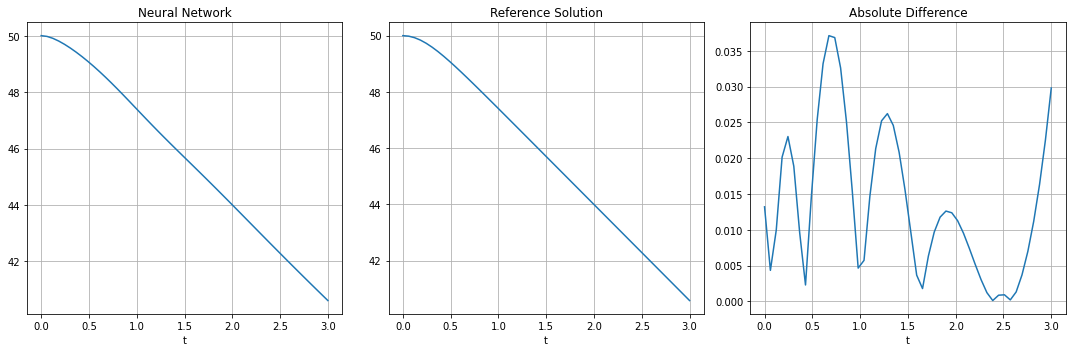

In [7]:
### Here, we preimplemented a check of the accruarcy of the model with the training set and a plot of 
### the solution for a given data set:
data_index_for_plot = 0

### First compute error:
model.to("cpu")
model_out = model(input_testing)
error = torch.abs(model_out - output_testing)
print("Relative error on the test data is:", torch.max(error) / torch.max(output_testing))

### Plot solution
import matplotlib.pyplot as plt
print("Showing D value:", input_testing[data_index_for_plot, 0, 0].item())
plt.figure(0, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(input_testing[data_index_for_plot, :, 1], model_out[data_index_for_plot].detach())
plt.title("Neural Network")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(input_testing[data_index_for_plot, :, 1], output_testing[data_index_for_plot])
plt.title("Reference Solution")
plt.xlabel("t")
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(input_testing[data_index_for_plot, :, 1], error[data_index_for_plot].detach())
plt.title("Absolute Difference")
plt.xlabel("t")
plt.grid()
plt.tight_layout()